<a id='notebook-top'></a>
This notebook shows the wavelength calibration of the red detector. Link to [Figure 15b](#figure-15b).

(The internal hyperlink only works on [GitHub Pages](https://yjzhu-solar.github.io/Eclipse2017/ipynb_html/wvl_calib_red_curv_corr.html) or [nbviewer](https://nbviewer.org/github/yjzhu-solar/Eclipse2017/blob/master/ipynb/eclipse_calib/wvl_calib_red_curv_corr.ipynb). Do not click when viewing the notebook on GitHub.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, SpectrumFitRow
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage

In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [3]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"
helium_im_collection = ImageFileCollection(red_path,
                            glob_include="HeliumrRedpoint01s_920*.fit")
helium_im_df = helium_im_collection.summary.to_pandas()

In [4]:
helium_im_df

file  simple  bitpix  naxis  naxis1  naxis2  \
0  HeliumrRedpoint01s_9200.fit    True      16      2    1392    1040   
1  HeliumrRedpoint01s_9201.fit    True      16      2    1392    1040   
2  HeliumrRedpoint01s_9202.fit    True      16      2    1392    1040   
3  HeliumrRedpoint01s_9203.fit    True      16      2    1392    1040   
4  HeliumrRedpoint01s_9204.fit    True      16      2    1392    1040   
5  HeliumrRedpoint01s_9205.fit    True      16      2    1392    1040   
6  HeliumrRedpoint01s_9206.fit    True      16      2    1392    1040   
7  HeliumrRedpoint01s_9207.fit    True      16      2    1392    1040   
8  HeliumrRedpoint01s_9208.fit    True      16      2    1392    1040   
9  HeliumrRedpoint01s_9209.fit    True      16      2    1392    1040   

     bzero  bscale  datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  \
0  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
1  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
2  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
3  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
4  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
5  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
6  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
7  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
8  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
9  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   

   yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  
0         0         0         0     719   14008  Artemis Capture  
1         0         0         0     719   13359  Artemis Capture  
2         0         0         0     723   17295  Artemis Capture  
3         0         0         0     725   17460  Artemis Capture  
4         0         0         0     724   15923  Artemis Capture  
5         0         0         0     718   13700  Artemis Capture  
6         0         0         0     718   15532  Artemis Capture  
7         0         0         0     717   14252  Artemis Capture  
8         0         0         0     718   13283  Artemis Capture  
9         0         0         0     717   15560  Artemis Capture  

[10 rows x 24 columns]

In [5]:
helium_image_cube = np.zeros((1040,1392,10))

for ii, row_ in helium_im_df.iterrows():
    helium_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

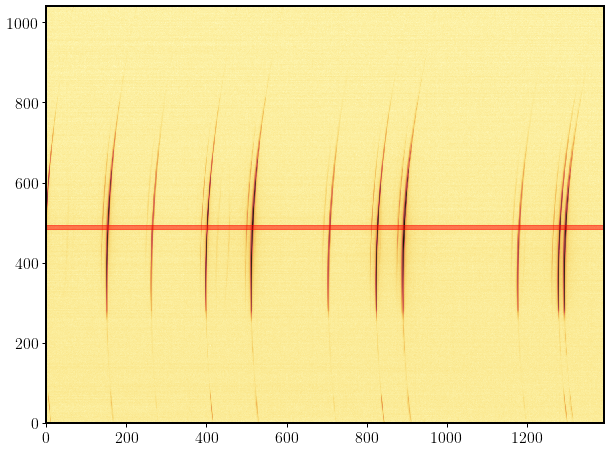

In [6]:
helium_im_aver = np.mean(helium_image_cube,axis=2)
norm = ImageNormalize(helium_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),helium_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
bottom_pixel = 485
top_pixel = 495
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

In [7]:
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_red.h5", 'r') as hf:
    xpos_map_coordinate = hf['xpos_map_coordinate'][:]
    xstart_pixel = hf['xpos_map_coordinate'].attrs['xstart_pixel']
    xend_pixel = hf['xpos_map_coordinate'].attrs['xend_pixel']

    ypos_map_coordinate = hf['ypos_map_coordinate'][:]
    ystart_pixel = hf['ypos_map_coordinate'].attrs['ystart_pixel']
    yend_pixel = hf['ypos_map_coordinate'].attrs['yend_pixel']


In [8]:
testx_slice_mapcoor = slice(xstart_pixel,xend_pixel)
testy_slice_mapcoor = slice(ystart_pixel,yend_pixel)
helium_trans_mapcoor = ndimage.map_coordinates(helium_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

Text(0, 0.5, '')

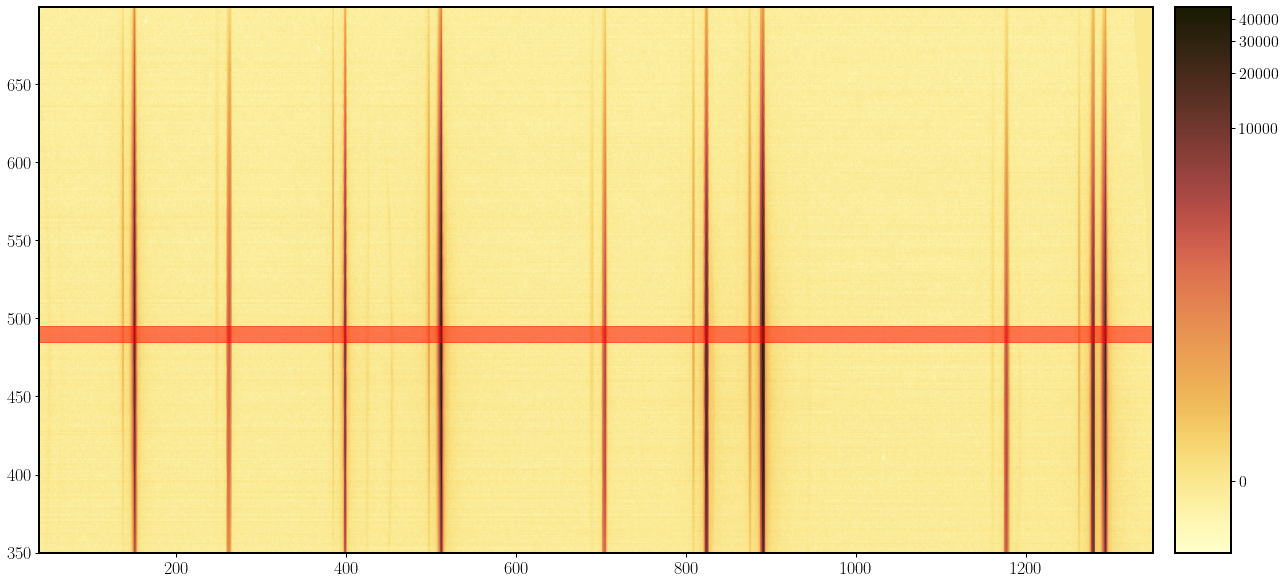

In [9]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            helium_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

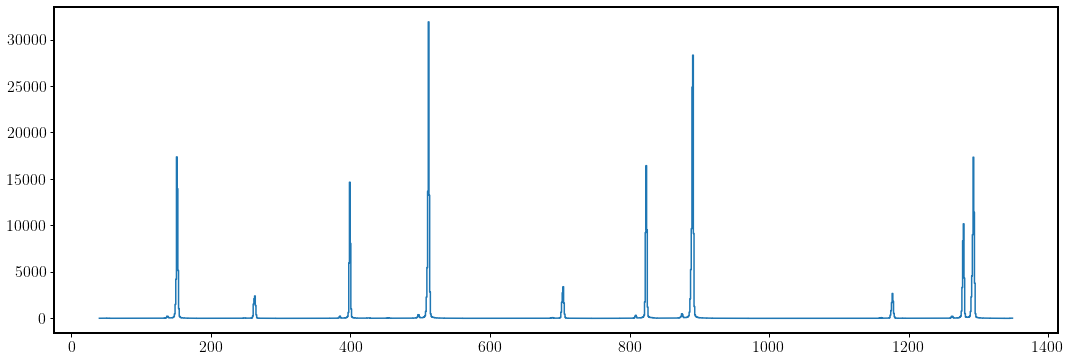

In [10]:
helium_spectrum_example = np.mean(helium_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ccdx_array = np.arange(xstart_pixel, xend_pixel)
ax.step(ccdx_array, helium_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

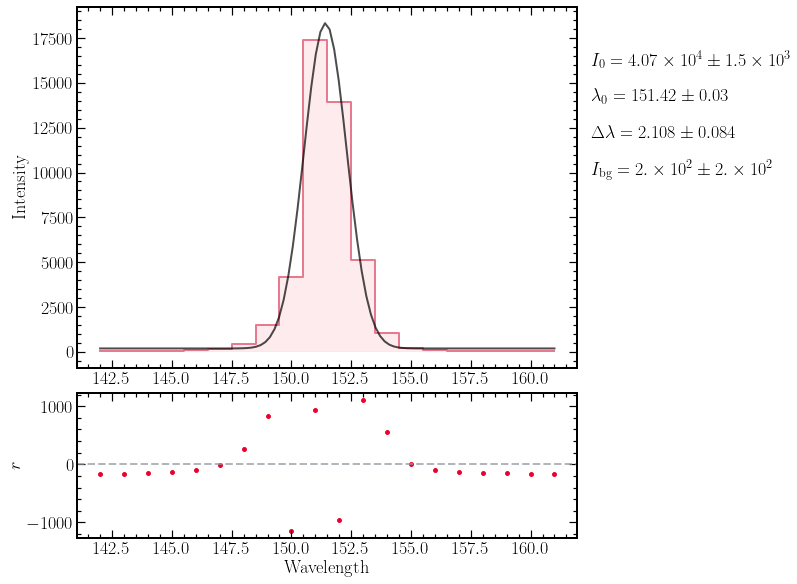

In [11]:
HeI_D3_slice_1 = slice(142 - xstart_pixel,162 - xstart_pixel)
HeI_D3_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_1], wvl=ccdx_array[HeI_D3_slice_1],line_number=1,line_wvl_init=[151],
                    int_max_init=[20000],fwhm_init=[1],same_width=False)
HeI_D3_model_1.run_lse(absolute_sigma=False)
HeI_D3_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

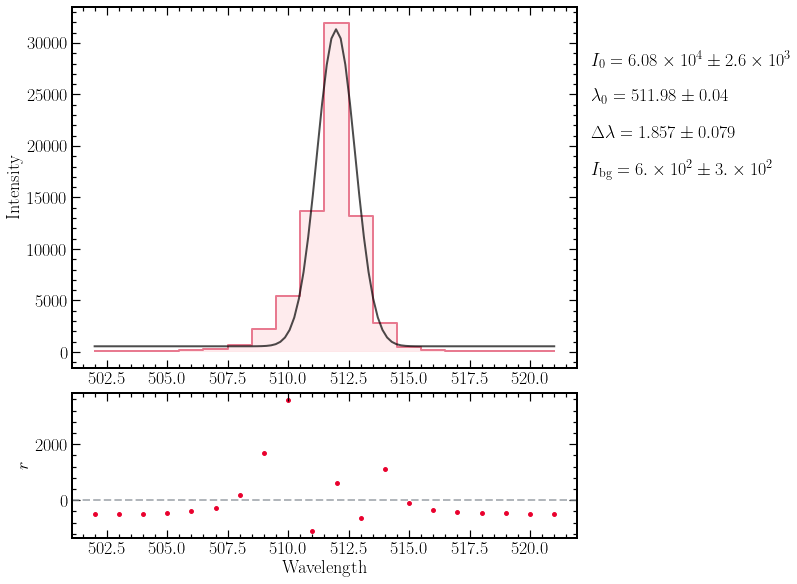

In [12]:
HeI_D3_slice_2 = slice(502 - xstart_pixel,522 - xstart_pixel)
HeI_D3_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_2], wvl=ccdx_array[HeI_D3_slice_2],line_number=1,line_wvl_init=[512],
                    int_max_init=[35000],fwhm_init=[1],same_width=False)
HeI_D3_model_2.run_lse(absolute_sigma=False)
HeI_D3_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

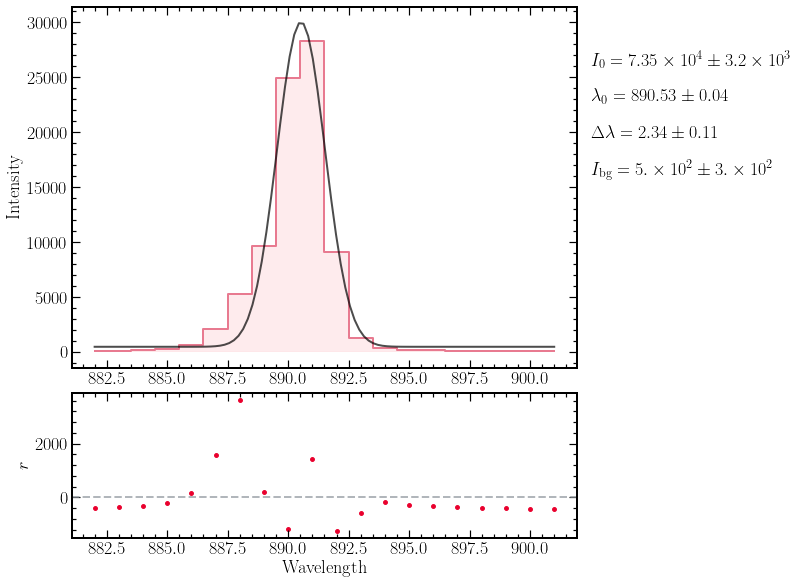

In [13]:
HeI_D3_slice_3 = slice(882 - xstart_pixel,902 - xstart_pixel)
HeI_D3_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_3], wvl=ccdx_array[HeI_D3_slice_3],line_number=1,line_wvl_init=[890],
                    int_max_init=[30000],fwhm_init=[2],same_width=False)
HeI_D3_model_3.run_lse(absolute_sigma=False)
HeI_D3_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

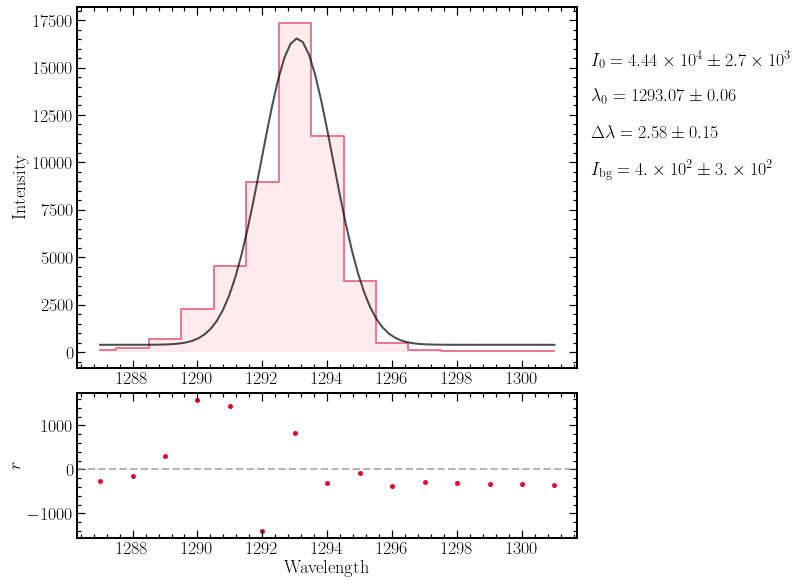

In [14]:
HeI_D3_slice_4 = slice(1287 - xstart_pixel,1302 - xstart_pixel)
HeI_D3_model_4 = SpectrumFitSingle(data=helium_spectrum_example[HeI_D3_slice_4], wvl=ccdx_array[HeI_D3_slice_4],line_number=1,line_wvl_init=[1294],
                    int_max_init=[17000],fwhm_init=[3],same_width=False)
HeI_D3_model_4.run_lse(absolute_sigma=False)
HeI_D3_model_4.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

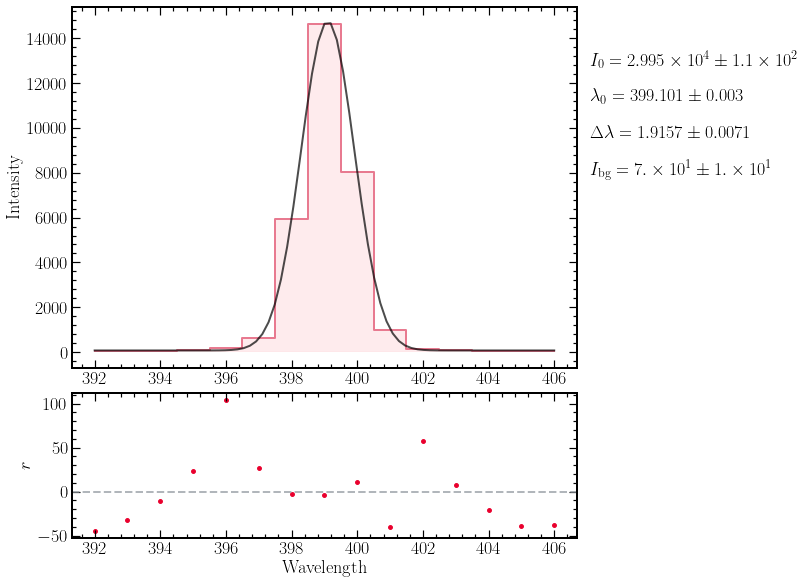

In [15]:
HeI_6678_slice_1 = slice(392 - xstart_pixel,407 - xstart_pixel)
HeI_6678_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_1], wvl=ccdx_array[HeI_6678_slice_1],line_number=1,line_wvl_init=[398],
                    int_max_init=[15000],fwhm_init=[1],same_width=False)
HeI_6678_model_1.run_lse(absolute_sigma=False)
HeI_6678_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

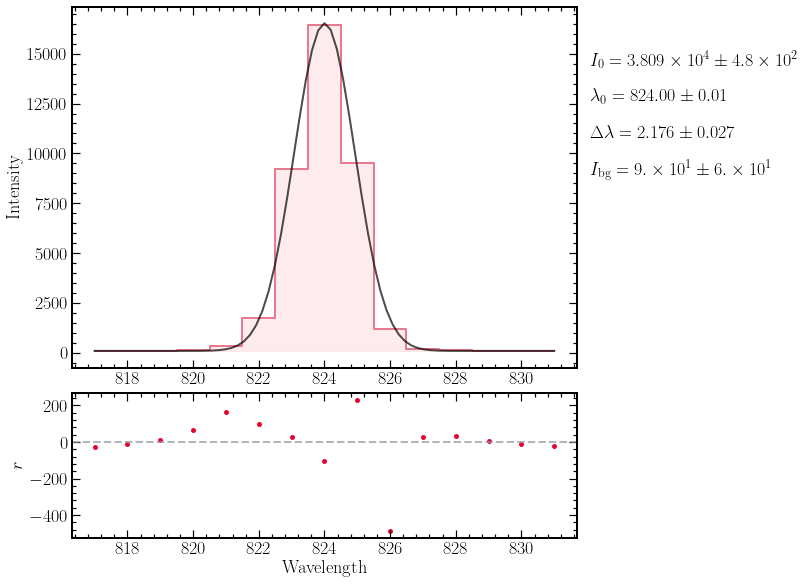

In [16]:
HeI_6678_slice_2 = slice(817 - xstart_pixel,832 - xstart_pixel)
HeI_6678_model_2 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_2], wvl=ccdx_array[HeI_6678_slice_2],line_number=1,line_wvl_init=[824],
                    int_max_init=[15000],fwhm_init=[3],same_width=False)
HeI_6678_model_2.run_lse(absolute_sigma=False)
HeI_6678_model_2.plot(plot_fit=True)

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:221: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


<AxesSubplot:ylabel='Intensity'>

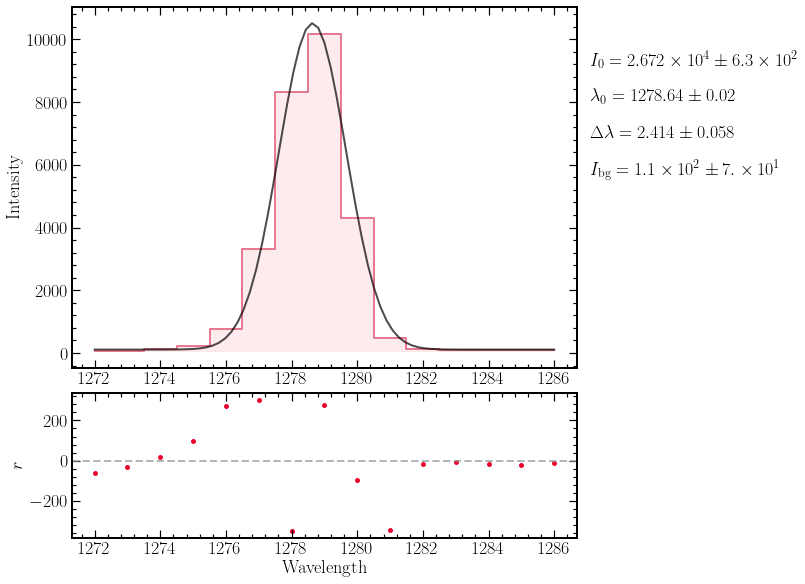

In [17]:
HeI_6678_slice_3 = slice(1272 - xstart_pixel,1287 - xstart_pixel)
HeI_6678_model_3 = SpectrumFitSingle(data=helium_spectrum_example[HeI_6678_slice_3], wvl=ccdx_array[HeI_6678_slice_3],line_number=1,line_wvl_init=[1279],
                    int_max_init=[12000],fwhm_init=[3],same_width=False)
HeI_6678_model_3.run_lse(absolute_sigma=True)
HeI_6678_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

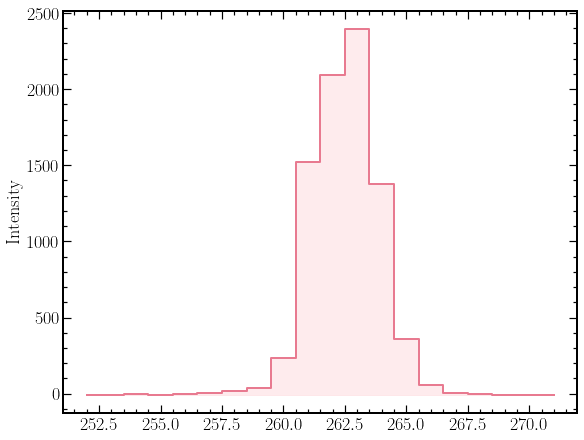

In [18]:
HeI_7066_slice_1 = slice(252 - xstart_pixel,272 - xstart_pixel)
HeI_7066_model_1 = SpectrumFitSingle(data=helium_spectrum_example[HeI_7066_slice_1], wvl=ccdx_array[HeI_7066_slice_1],line_number=1,line_wvl_init=[401],
                    int_max_init=[15000],fwhm_init=[1],same_width=False)
# HeI_7066_model_1.run_lse(absolute_sigma=False)
HeI_7066_model_1.plot(plot_fit=False)

In [19]:
HeI_D3_pos = np.array([HeI_D3_model.line_wvl_fit[0] for HeI_D3_model in 
                    (HeI_D3_model_1, HeI_D3_model_2, HeI_D3_model_3, HeI_D3_model_4)])
                    
HeI_6678_pos = np.array([HeI_6678_model.line_wvl_fit[0] for HeI_6678_model in 
                    (HeI_6678_model_1, HeI_6678_model_2, HeI_6678_model_3)])

In [20]:
HeI_D3_pos

array([ 151.42087797,  511.98042575,  890.53249223, 1293.07419638])

In [21]:
HeI_D3_pos[1:] - HeI_D3_pos[:-1]

array([360.55954777, 378.55206649, 402.54170415])

In [22]:
HeI_6678_pos

array([ 399.10069904,  824.0045151 , 1278.63884219])

In [23]:
HeI_6678_pos[1:] - HeI_6678_pos[:-1]

array([424.90381606, 454.63432709])

In [24]:
hydrogen_im_collection = ImageFileCollection(red_path,
                            glob_include="HydrogenRedpoint1s_947*.fit")
hydrogen_im_df = hydrogen_im_collection.summary.to_pandas()

In [25]:
hydrogen_im_df

file  simple  bitpix  naxis  naxis1  naxis2  \
0  HydrogenRedpoint1s_9470.fit    True      16      2    1392    1040   
1  HydrogenRedpoint1s_9471.fit    True      16      2    1392    1040   
2  HydrogenRedpoint1s_9472.fit    True      16      2    1392    1040   
3  HydrogenRedpoint1s_9473.fit    True      16      2    1392    1040   
4  HydrogenRedpoint1s_9474.fit    True      16      2    1392    1040   
5  HydrogenRedpoint1s_9475.fit    True      16      2    1392    1040   
6  HydrogenRedpoint1s_9476.fit    True      16      2    1392    1040   
7  HydrogenRedpoint1s_9477.fit    True      16      2    1392    1040   
8  HydrogenRedpoint1s_9478.fit    True      16      2    1392    1040   
9  HydrogenRedpoint1s_9479.fit    True      16      2    1392    1040   

     bzero  bscale  datamin  datamax  ... ypixsz  xbinning ybinning  xorgsubf  \
0  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
1  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
2  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
3  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
4  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
5  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
6  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
7  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
8  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   
9  32768.0     1.0      0.0  65535.0  ...   6.45         1        1         0   

   yorgsubf  xpossubf  ypossubf  cblack  cwhite         swcreate  
0         0         0         0     726   25799  Artemis Capture  
1         0         0         0     730   24838  Artemis Capture  
2         0         0         0     730   24237  Artemis Capture  
3         0         0         0     732   25086  Artemis Capture  
4         0         0         0     732   25004  Artemis Capture  
5         0         0         0     726   24843  Artemis Capture  
6         0         0         0     723   24729  Artemis Capture  
7         0         0         0     724   24676  Artemis Capture  
8         0         0         0     728   23696  Artemis Capture  
9         0         0         0     726   26298  Artemis Capture  

[10 rows x 24 columns]

In [26]:
hydrogen_image_cube = np.zeros((1040,1392,10))

for ii, row_ in hydrogen_im_df.iterrows():
    hydrogen_image_cube[:,:,ii] = CCDData.read(os.path.join(red_path,row_["file"]),unit="adu").data - bias_dc_red_1s

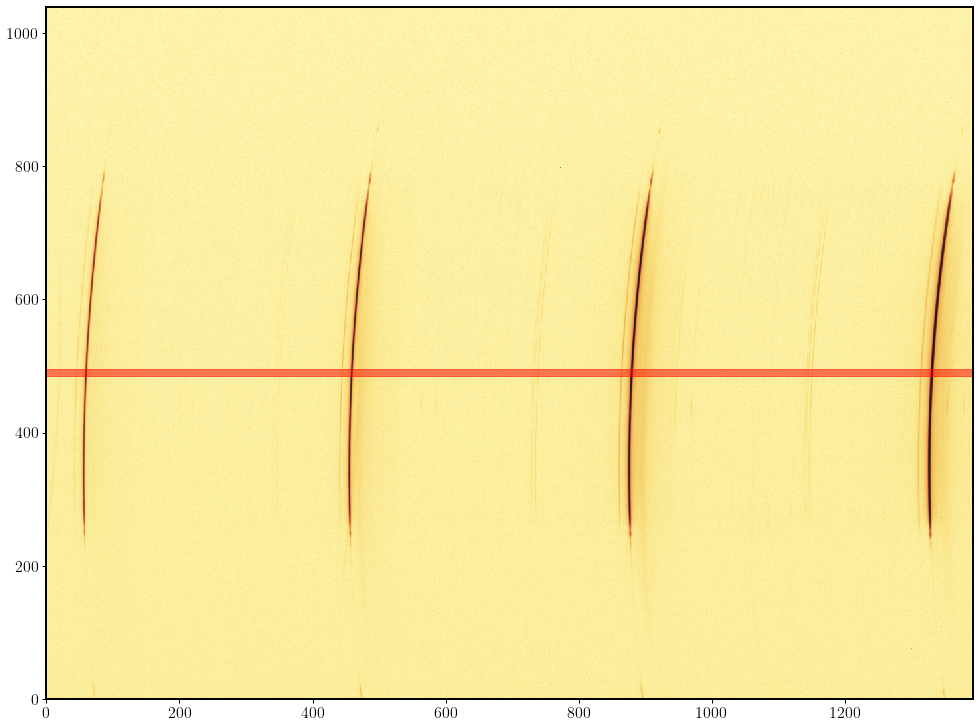

In [27]:
hydrogen_im_aver = np.mean(hydrogen_image_cube,axis=2)
norm = ImageNormalize(hydrogen_im_aver, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(16,10),constrained_layout=True)
ax.pcolormesh(np.arange(1392),np.arange(1040),hydrogen_im_aver,norm=norm,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)

ax.tick_params(labelsize=16)

In [28]:
hydrogen_trans_mapcoor = ndimage.map_coordinates(hydrogen_im_aver[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

Text(0, 0.5, '')

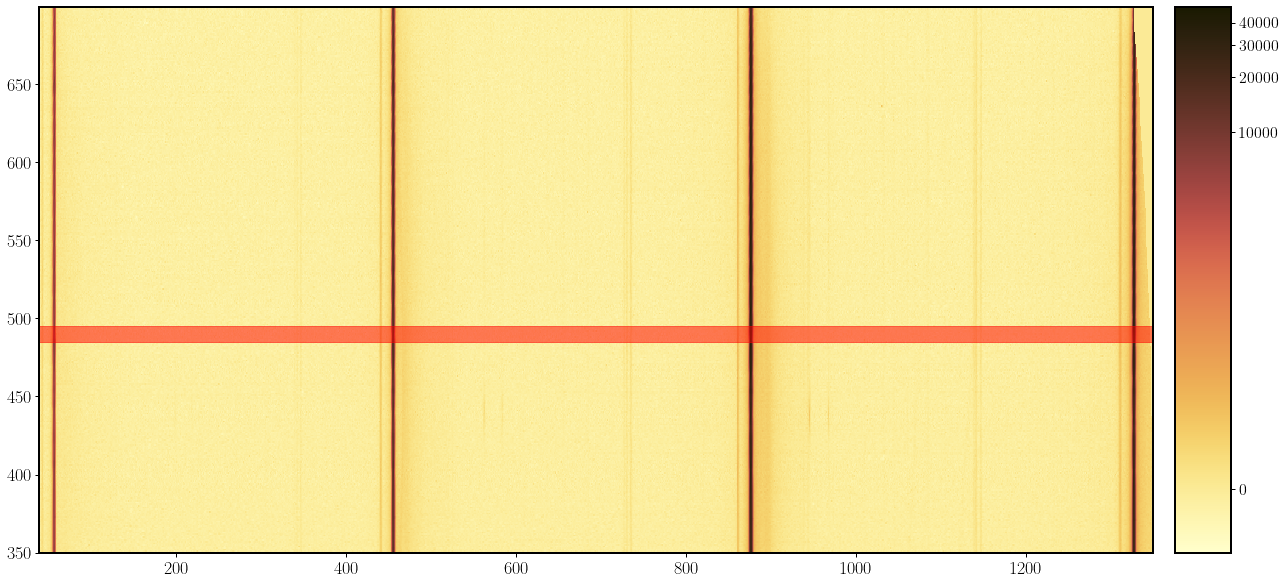

In [29]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            hydrogen_trans_mapcoor,norm=norm,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

(850.0, 900.0)

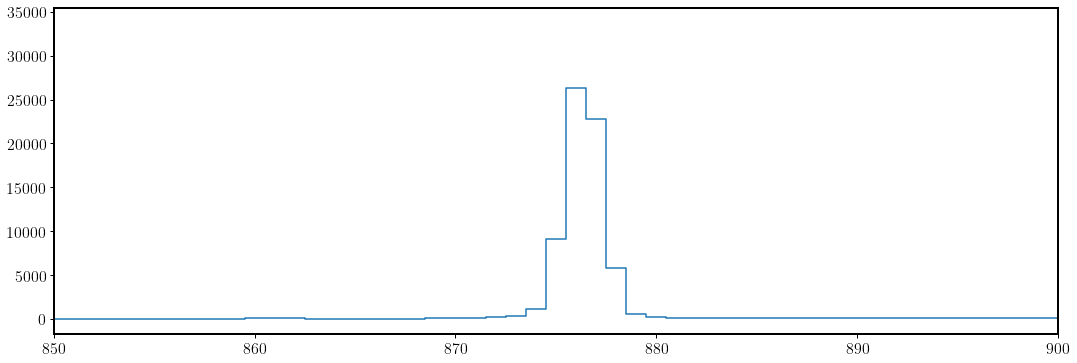

In [30]:
fig, ax = plt.subplots(figsize=(18,6))
ax.step(ccdx_array,  hydrogen_trans_mapcoor[96,:],where="mid")
ax.tick_params(labelsize=16)
ax.set_xlim(850,900)

(850.0, 900.0)

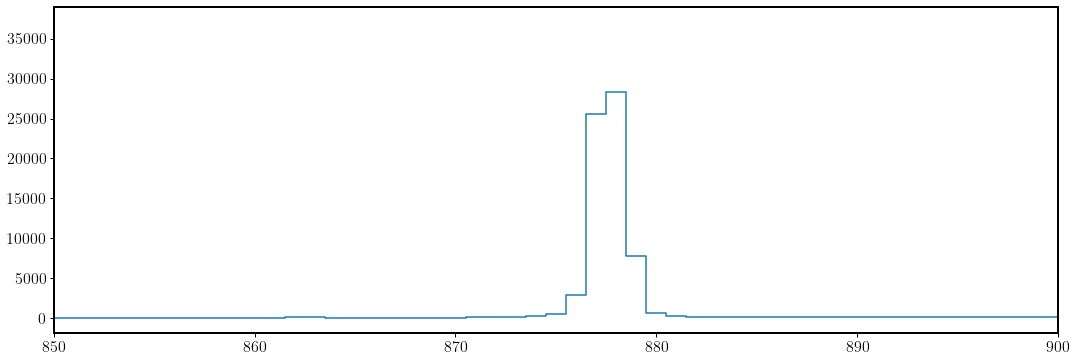

In [31]:
fig, ax = plt.subplots(figsize=(18,6))
ax.step(np.arange(1392),  hydrogen_im_aver[446,:],where="mid")
ax.tick_params(labelsize=16)
ax.set_xlim(850,900)

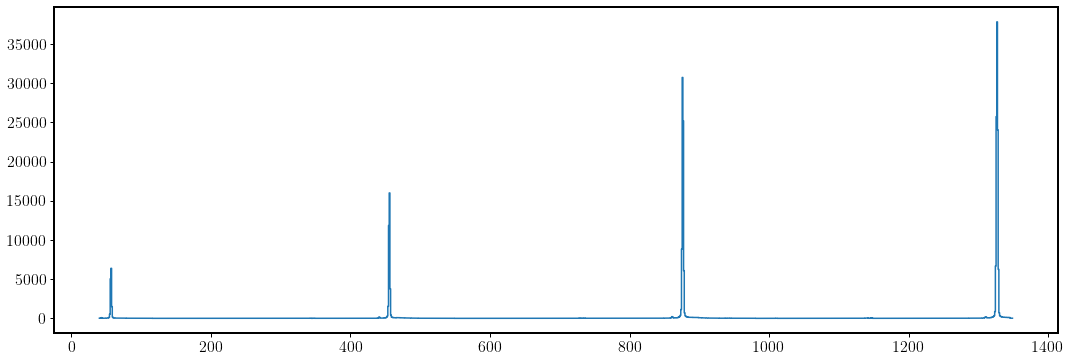

In [32]:
hydrogen_spectrum_example = np.mean(hydrogen_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ax.step(ccdx_array, hydrogen_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

<AxesSubplot:ylabel='Intensity'>

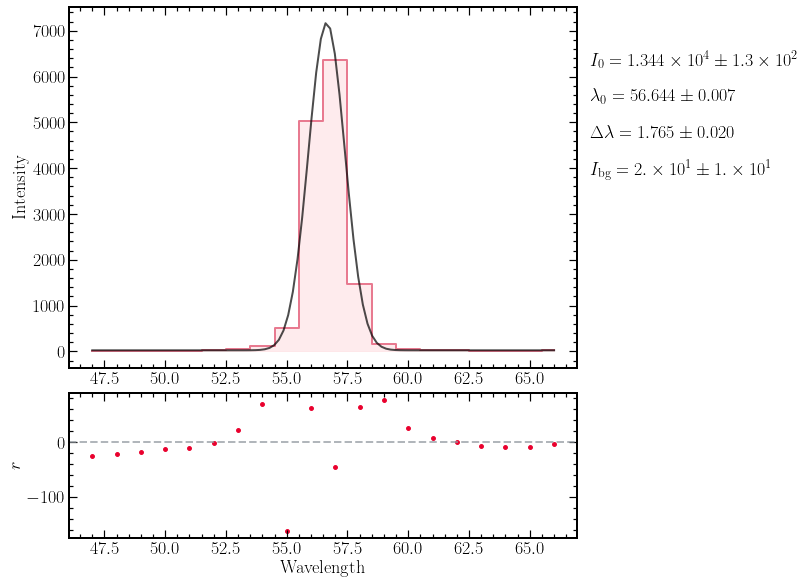

In [33]:
Halpha_slice_1 = slice(47 - xstart_pixel,67 - xstart_pixel)
Halpha_model_1 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_1], wvl=ccdx_array[Halpha_slice_1],line_number=1,line_wvl_init=[56],
                    int_max_init=[6000],fwhm_init=[1],same_width=False)
Halpha_model_1.run_lse(absolute_sigma=False)
Halpha_model_1.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

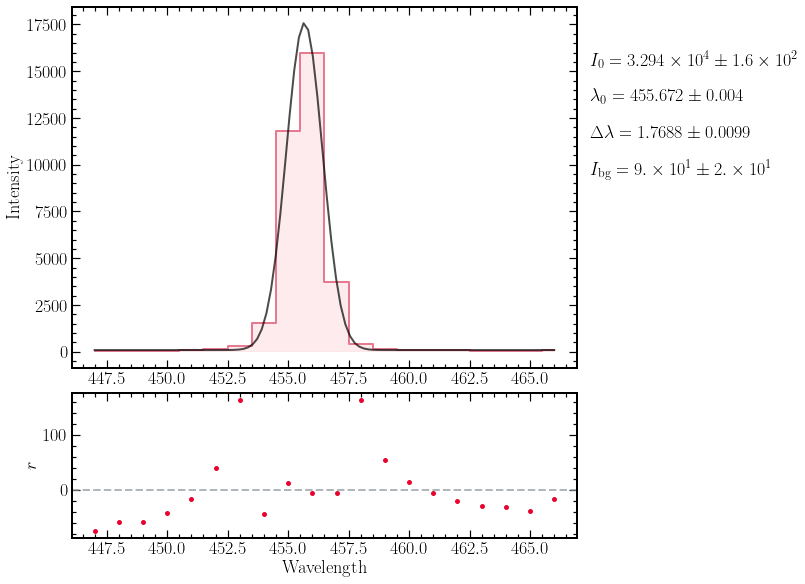

In [34]:
Halpha_slice_2 = slice(447 - xstart_pixel,467 - xstart_pixel)
Halpha_model_2 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_2], wvl=ccdx_array[Halpha_slice_2],line_number=1,line_wvl_init=[455],
                    int_max_init=[17000],fwhm_init=[1],same_width=False)
Halpha_model_2.run_lse(absolute_sigma=False)
Halpha_model_2.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

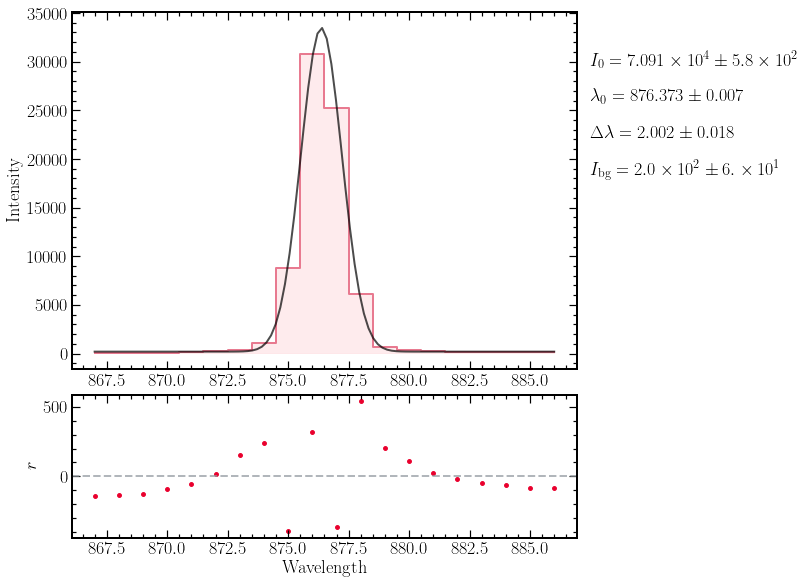

In [35]:
Halpha_slice_3 = slice(867 - xstart_pixel,887 - xstart_pixel)
Halpha_model_3 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_3], wvl=ccdx_array[Halpha_slice_3],line_number=1,line_wvl_init=[877],
                    int_max_init=[30000],fwhm_init=[1],same_width=False)
Halpha_model_3.run_lse(absolute_sigma=False)
Halpha_model_3.plot(plot_fit=True)

<AxesSubplot:ylabel='Intensity'>

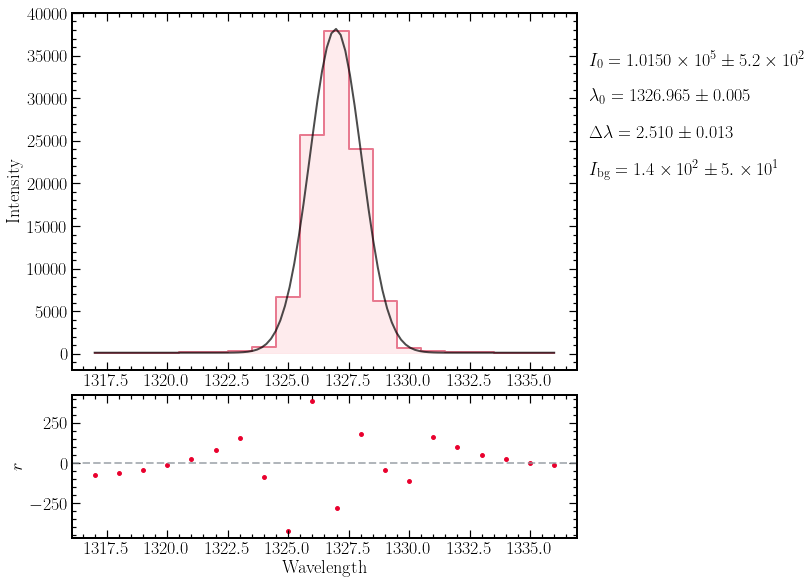

In [36]:
Halpha_slice_4 = slice(1317 - xstart_pixel,1337 - xstart_pixel)
Halpha_model_4 = SpectrumFitSingle(data=hydrogen_spectrum_example[Halpha_slice_4], wvl=ccdx_array[Halpha_slice_4],line_number=1,line_wvl_init=[1327],
                    int_max_init=[40000],fwhm_init=[1],same_width=False)
Halpha_model_4.run_lse(absolute_sigma=False)
Halpha_model_4.plot(plot_fit=True)

In [37]:
Halpha_pos = np.array([Halpha_model.line_wvl_fit[0] for Halpha_model in 
                    (Halpha_model_1, Halpha_model_2, Halpha_model_3, Halpha_model_4)])

In [38]:
Halpha_pos[1:] - Halpha_pos[:-1]

array([399.02799639, 420.70144803, 450.59173664])

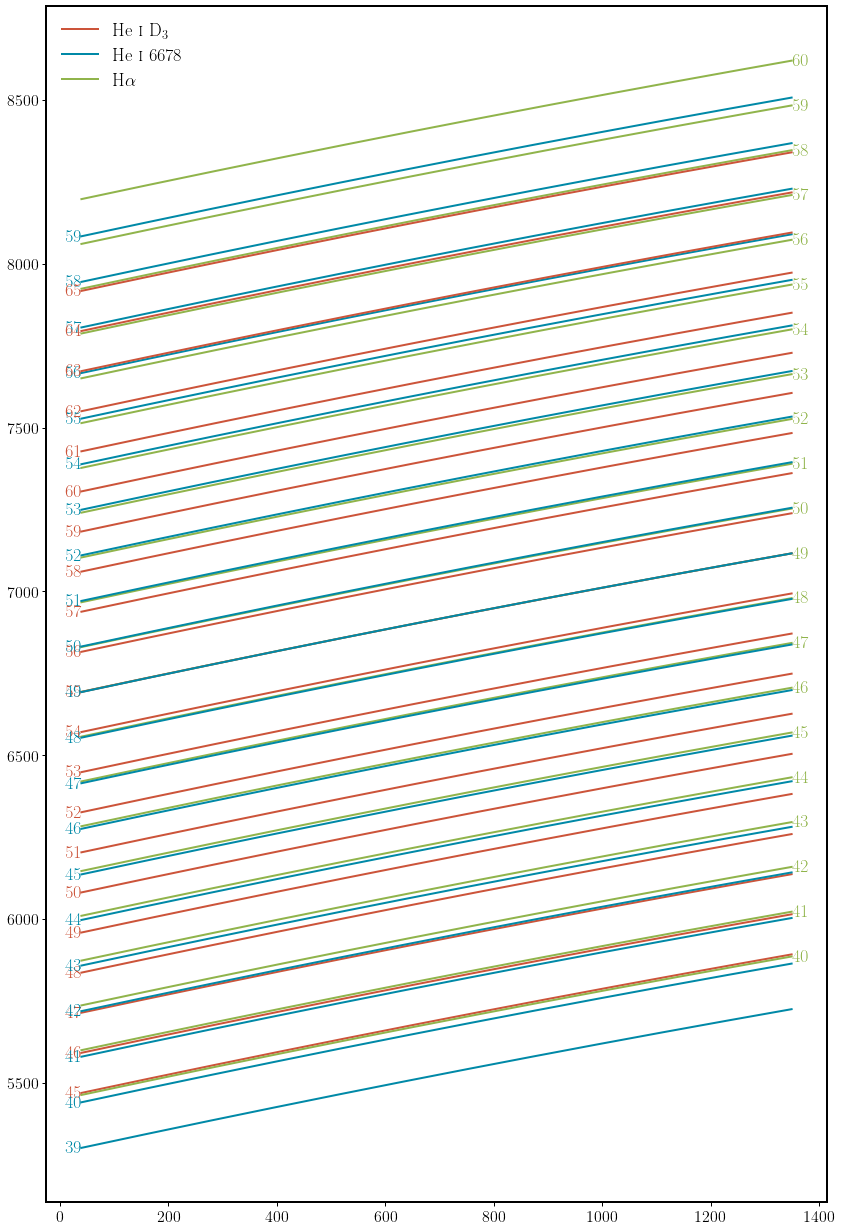

In [39]:
scale_factor = 48
HeI_D3_start_order_guess = 55
HeI_6678_start_order_guess = 49
Halpha_start_order_guess = 50

order_variation = 10
fig, ax = plt.subplots(figsize=(14,order_variation*2 + 2))

for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                             HeI_D3_start_order_guess + order_new + 4 )/scale_factor
    HeI_6678_wvl_guess_new = 6678.151 * np.arange(HeI_6678_start_order_guess + order_new,
                                HeI_6678_start_order_guess + order_new +3)/scale_factor
    Halpha_wvl_guess_new = 6562.79  * np.arange(Halpha_start_order_guess + order_new,
                             Halpha_start_order_guess + order_new + 4 )/scale_factor
    
    poly_fit_d3_param = np.polyfit(HeI_D3_pos, HeI_D3_wvl_guess_new, 2)
    poly_fit_d3_func = np.poly1d(poly_fit_d3_param)
    poly_fit_d3_curve = poly_fit_d3_func(ccdx_array)

    poly_fit_6678_param = np.polyfit(HeI_6678_pos, HeI_6678_wvl_guess_new, 2)
    poly_fit_6678_func = np.poly1d(poly_fit_6678_param)
    poly_fit_6678_curve = poly_fit_6678_func(ccdx_array)

    poly_fit_halpha_param = np.polyfit(Halpha_pos, Halpha_wvl_guess_new, 2)
    poly_fit_halpha_func = np.poly1d(poly_fit_halpha_param)
    poly_fit_halpha_curve = poly_fit_halpha_func(ccdx_array)

    ln1, = ax.plot(ccdx_array, poly_fit_d3_curve,color="#CC543A",lw=2,
            label=r"He \textsc{i} $\rm D_3$")
    ax.text(ccdx_array[0], poly_fit_d3_curve[0],"{:2d}".format(HeI_D3_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#CC543A")

    ln2, = ax.plot(ccdx_array, poly_fit_6678_curve,color="#0089A7",lw=2,
            label=r"He \textsc{i} 6678")
    ax.text(ccdx_array[0], poly_fit_6678_curve[0],"{:2d}".format(HeI_6678_start_order_guess + order_new),
            va="center",ha="right",fontsize=18,color="#0089A7")

    ln3, = ax.plot(ccdx_array, poly_fit_halpha_curve,color="#90B44B",lw=2,
            label=r"H$\alpha$")
    ax.text(ccdx_array[-1], poly_fit_halpha_curve[-1],"{:2d}".format(Halpha_start_order_guess + order_new),
            va="center",ha="left",fontsize=18,color="#90B44B")

    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

ax.tick_params(labelsize=16)



Text(0, 0.5, 'Wavelength $\\lambda$\\,[\\mbox{\\AA}]')

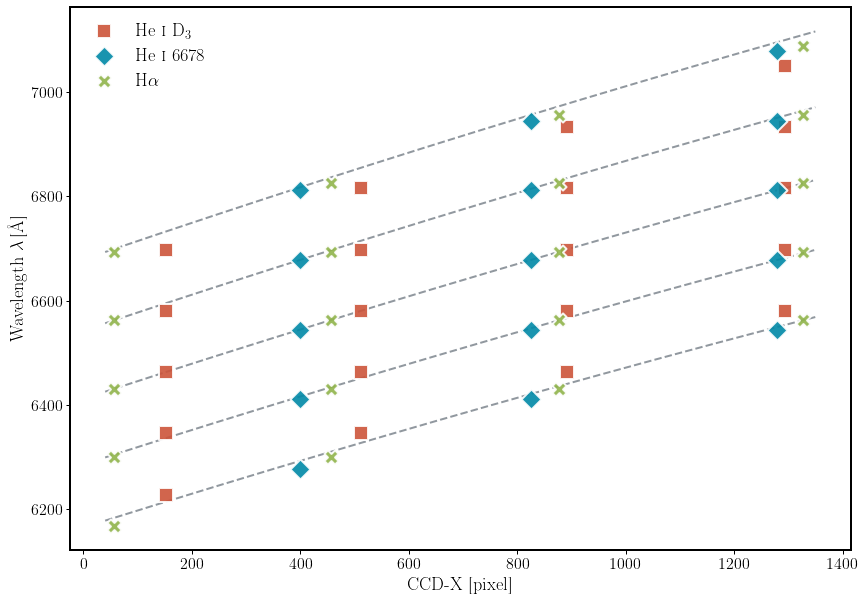

In [40]:
base_order = 50
HeI_D3_start_order_guess = 55
HeI_6678_start_order_guess = 49
Halpha_start_order_guess = 49

HeI_D3_wvl_guess = 5875.621 * np.arange(HeI_D3_start_order_guess, HeI_D3_start_order_guess + 4)/base_order
HeI_6678_wvl_guess = 6678.151 * np.arange(HeI_6678_start_order_guess, HeI_6678_start_order_guess + 3)/base_order
Halpha_wvl_guess = 6562.79 * np.arange(Halpha_start_order_guess, Halpha_start_order_guess + 4)/base_order

line_pos_all = np.concatenate([HeI_D3_pos, HeI_6678_pos,Halpha_pos])
line_wvl_guess_all = np.concatenate([HeI_D3_wvl_guess, HeI_6678_wvl_guess,Halpha_wvl_guess])

poly_fit_param = np.polyfit(line_pos_all, line_wvl_guess_all, 2)
poly_fit_func = np.poly1d(poly_fit_param)
poly_fit_curve = poly_fit_func(ccdx_array)
red_abs_shift = 1.173
poly_fit_curve_shift = poly_fit_func(ccdx_array - red_abs_shift)

order_variation = 2
fig, ax = plt.subplots(figsize=(14,order_variation*4 + 2))


for ii, order_new in enumerate(np.arange(-order_variation, order_variation + 1)):
    HeI_D3_wvl_guess_new = 5875.621 * np.arange(HeI_D3_start_order_guess + order_new,
                             HeI_D3_start_order_guess + order_new + 4 )/base_order
    HeI_6678_wvl_guess_new = 6678.151 * np.arange(HeI_6678_start_order_guess + order_new,
                                HeI_6678_start_order_guess + order_new +3)/base_order
    Halpha_wvl_guess_new = 6562.79 * np.arange(Halpha_start_order_guess + order_new,
                                Halpha_start_order_guess + order_new +4)/base_order

    ln1 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess_new,marker= "s",s=200,facecolor="#CC543A",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} $\rm D_3$")
    ln2 = ax.scatter(HeI_6678_pos, HeI_6678_wvl_guess_new,marker= "D",s=200,facecolor="#0089A7",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"He \textsc{i} 6678")
    ln3 = ax.scatter(Halpha_pos, Halpha_wvl_guess_new,marker= "X",s=200,facecolor="#90B44B",
                alpha=0.9,edgecolor='white',linewidth=2,label=r"H$\alpha$")
    if ii == order_variation*2:
        leg = [ln1,ln2,ln3]
        ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

    ax.plot(ccdx_array, poly_fit_curve*base_order/(base_order + order_new),lw=2,ls="--",color="#91989F",zorder=0)


# for plot_order in np.arange(base_order - 5, base_order + 5):
#     ax.scatter()

ax.tick_params(labelsize=16)
ax.set_xlabel("CCD-X [pixel]",fontsize=18)
ax.set_ylabel(r"Wavelength $\lambda$\,[\mbox{\AA}]",fontsize=18)

In [41]:
totality_image_fname = "TotalitySequenceRed_7723.fit"
totality_frame = CCDData.read(os.path.join(red_path, totality_image_fname),unit="adu")

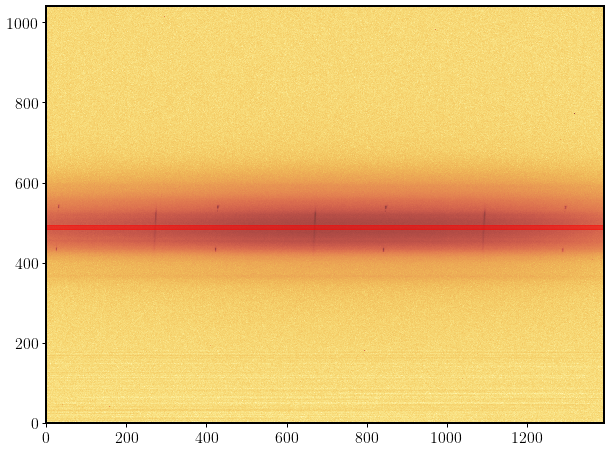

In [42]:
totality_image = (totality_frame.data - bias_dc_red_1s)//totality_frame.header["EXPTIME"]
norm_totality = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm_totality,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
ax.tick_params(labelsize=16)

In [43]:
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

Text(0, 0.5, '')

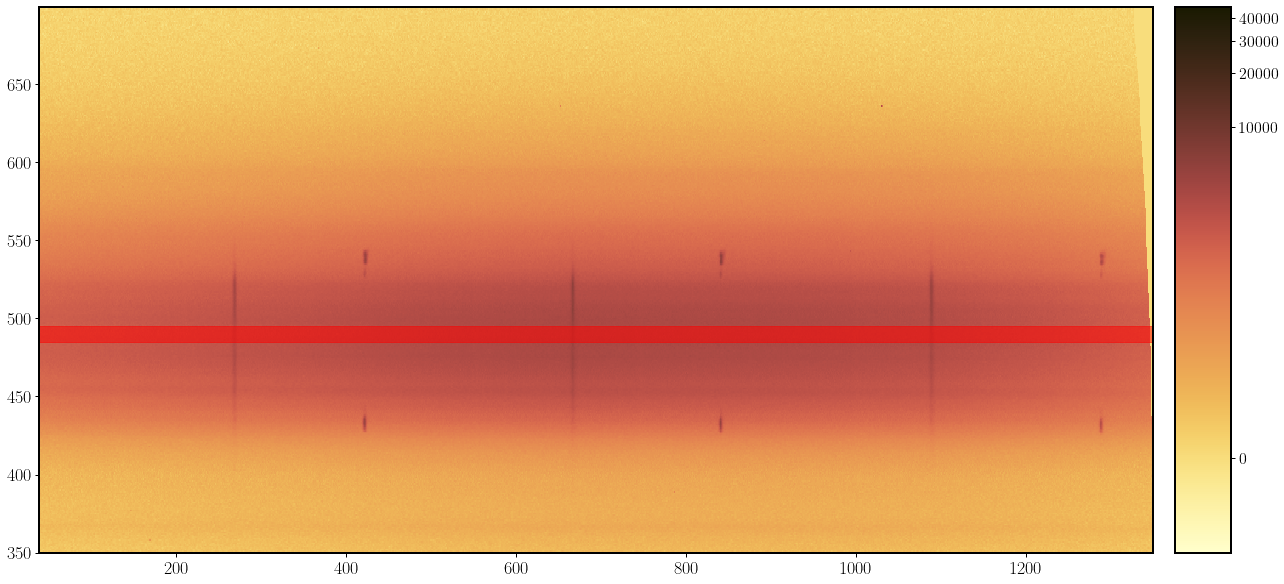

In [44]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,norm=norm_totality,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
ax.axhspan(bottom_pixel,top_pixel,color="red",alpha=0.5)
clb_ax = inset_axes(ax,width="5%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)

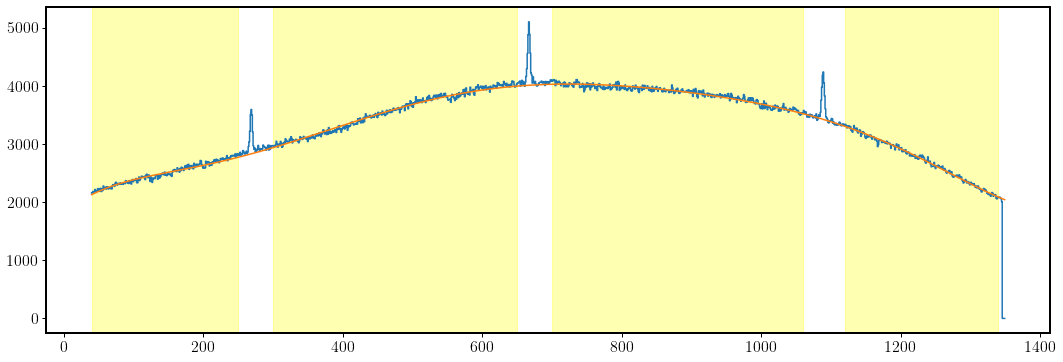

In [45]:
totality_spectrum_example = np.mean(totality_trans_mapcoor[bottom_pixel - ystart_pixel:top_pixel - ystart_pixel,:],axis=0)
fig, ax = plt.subplots(figsize=(18,6))
ax.step(ccdx_array, totality_spectrum_example,where="mid")
ax.tick_params(labelsize=16)

fit_intervals = [slice(0,210),slice(260,610),slice(660,1020),slice(1080,1300)]
for fit_interval in fit_intervals:
    ax.axvspan(fit_interval.start + xstart_pixel,fit_interval.stop + xstart_pixel,color="yellow",alpha=0.3)

background_poly_order = 7
wvl_array_to_fit = np.concatenate([ccdx_array[fit_interval] for fit_interval in fit_intervals])
spectra_to_fit = np.concatenate([totality_spectrum_example[fit_interval] for fit_interval in fit_intervals])
background_poly_params = np.polyfit(wvl_array_to_fit,spectra_to_fit,background_poly_order)
background_poly_func = np.poly1d(background_poly_params)
background_poly_curve = background_poly_func(ccdx_array)

ax.plot(ccdx_array, background_poly_curve, label="{:.0f}th".format(background_poly_order))

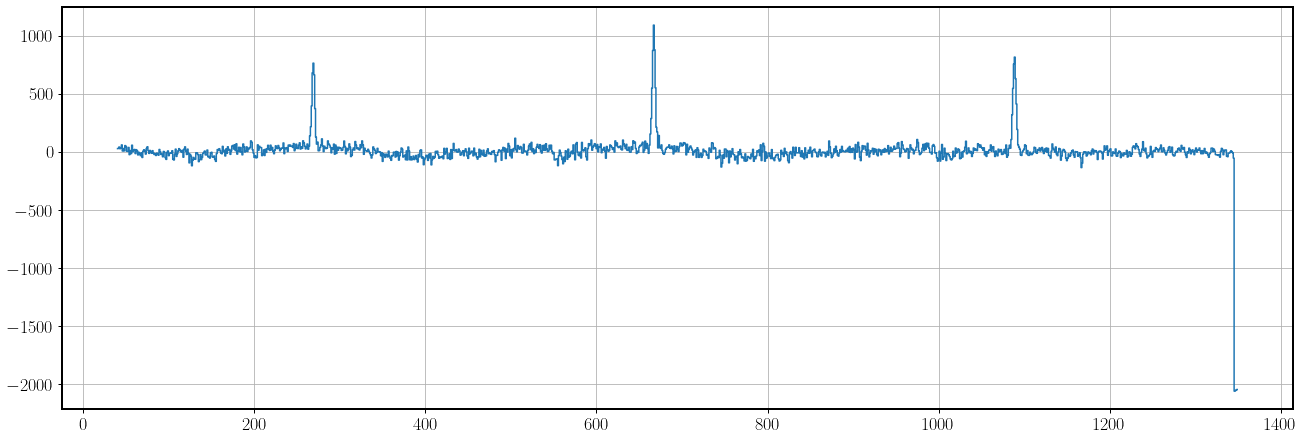

In [46]:
totality_spectrum_no_background = totality_spectrum_example - background_poly_curve
fig, ax = plt.subplots(figsize=(18,6),constrained_layout=True)
ax.step(ccdx_array, totality_spectrum_no_background, where="mid")
ax.tick_params(labelsize=18)
ax.grid("on")

<AxesSubplot:ylabel='Intensity'>

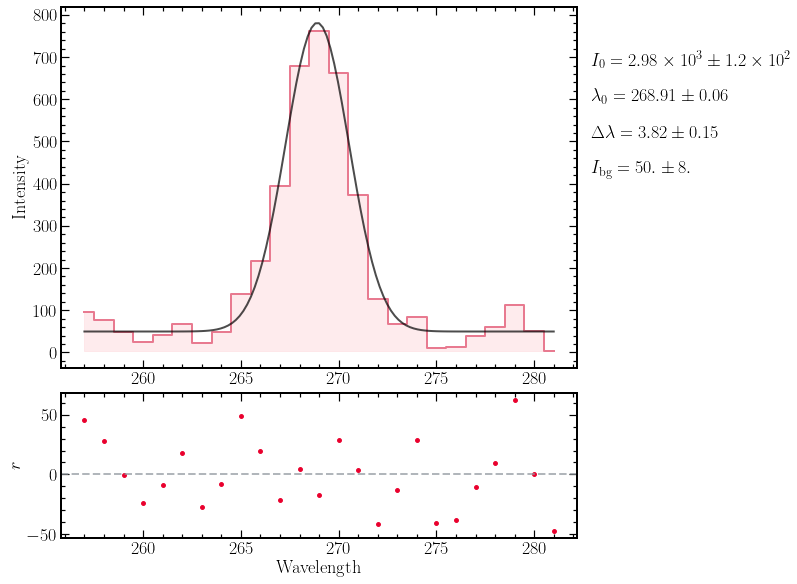

In [47]:
FeX_6374_slice_1 = slice(257 - xstart_pixel,282 - xstart_pixel)
FeX_6374_model_1 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_1], wvl=ccdx_array[FeX_6374_slice_1],line_number=1,line_wvl_init=[269],
                    int_max_init=[700],fwhm_init=[1],same_width=False)
FeX_6374_model_1.run_lse(absolute_sigma=False)
FeX_6374_model_1.plot(plot_fit=True)

In [48]:
poly_fit_func(FeX_6374_model_1.line_wvl_fit[0])*base_order/6374.51

51.00170014611809

In [49]:
vac_to_air(6376.2900*u.Angstrom)

<Quantity 6374.43055223 Angstrom>

<AxesSubplot:ylabel='Intensity'>

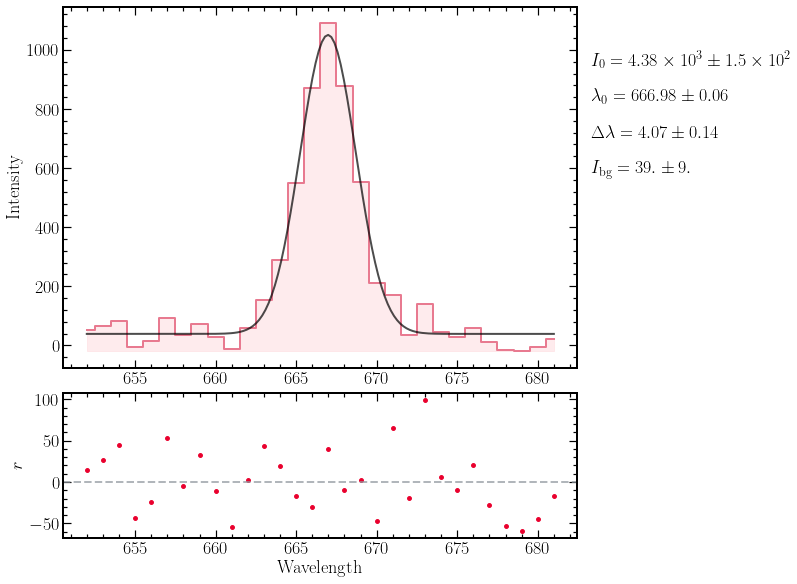

In [50]:
FeX_6374_slice_2 = slice(652 - xstart_pixel,682 - xstart_pixel)
FeX_6374_model_2 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_2], wvl=ccdx_array[FeX_6374_slice_2],line_number=1,line_wvl_init=[667],
                    int_max_init=[1000],fwhm_init=[1],same_width=False)
FeX_6374_model_2.run_lse(absolute_sigma=False)
FeX_6374_model_2.plot(plot_fit=True)

In [51]:
poly_fit_func(FeX_6374_model_2.line_wvl_fit[0])*base_order/6374.51

52.00141905680704

<AxesSubplot:ylabel='Intensity'>

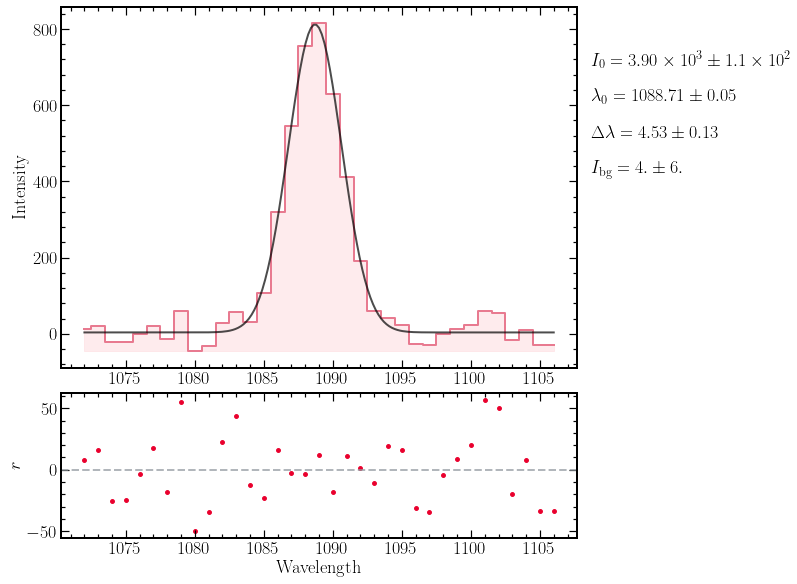

In [52]:
FeX_6374_slice_3 = slice(1072 - xstart_pixel,1107 - xstart_pixel)
FeX_6374_model_3 = SpectrumFitSingle(data=totality_spectrum_no_background[FeX_6374_slice_3], wvl=ccdx_array[FeX_6374_slice_3],line_number=1,line_wvl_init=[1089],
                    int_max_init=[8000],fwhm_init=[3],same_width=False)
FeX_6374_model_3.run_lse(absolute_sigma=False)
FeX_6374_model_3.plot(plot_fit=True)

In [53]:
poly_fit_func(FeX_6374_model_3.line_wvl_fit[0])*base_order/6374.51

52.9998944568259

In [54]:
FeX_6374_pos = np.array([FeX_6374_model.line_wvl_fit[0] for FeX_6374_model in 
                    (FeX_6374_model_1, FeX_6374_model_2, FeX_6374_model_3)])


<a id='figure-15b'></a>
### Figure 15b
[back to top](#notebook-top) 

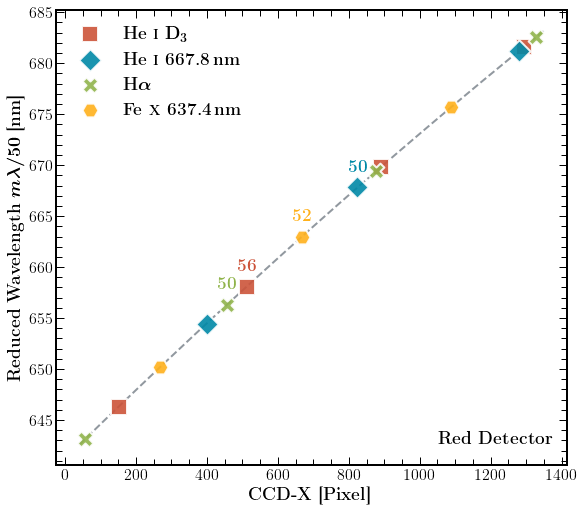

In [55]:
FeX_6374_start_order_guess = 51
FeX_6374_wvl_guess = 6374.51 * np.arange(FeX_6374_start_order_guess, FeX_6374_start_order_guess + 3)/base_order

fig, ax = plt.subplots(figsize=(8,7),constrained_layout=True)

ln1 = ax.scatter(HeI_D3_pos, HeI_D3_wvl_guess/10.,marker= "s",s=250,facecolor="#CC543A",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i}} $\boldsymbol{\rm D_3}$")
ln2 = ax.scatter(HeI_6678_pos, HeI_6678_wvl_guess/10.,marker= "D",s=250,facecolor="#0089A7",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{He \textsc{i} 667.8\,nm}")
ln3 = ax.scatter(Halpha_pos, Halpha_wvl_guess/10.,marker= "X",s=250,facecolor="#90B44B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{H}$\boldsymbol{\alpha}$")
ln4 = ax.scatter(FeX_6374_pos, FeX_6374_wvl_guess/10.,marker= "H",s=250,facecolor="#FFB11B",
            alpha=0.9,edgecolor='white',linewidth=2,label=r"\textbf{Fe \textsc{x} 637.4\,nm}")

leg = [ln1,ln2,ln3,ln4]
ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)

ax.plot(ccdx_array, poly_fit_curve/10.,lw=2,ls="--",color="#91989F",zorder=0)
ax.text(Halpha_pos[1], (Halpha_wvl_guess[1]+20)/10., r"\textbf{{{:2d}}}".format(Halpha_start_order_guess+1),color="#90B44B",
        fontsize=18,ha="center",va="center")
ax.text(HeI_D3_pos[1], (HeI_D3_wvl_guess[1]+20)/10., r"\textbf{{{:2d}}}".format(HeI_D3_start_order_guess+1),color="#CC543A",
        fontsize=18,ha="center",va="center")
ax.text(HeI_6678_pos[1], (HeI_6678_wvl_guess[1]+20)/10., r"\textbf{{{:2d}}}".format(HeI_6678_start_order_guess+1),color="#0089A7",
        fontsize=18,ha="center",va="center")
ax.text(FeX_6374_pos[1], (FeX_6374_wvl_guess[1]+20)/10., r"\textbf{{{:2d}}}".format(FeX_6374_start_order_guess+1),color="#FFB11B",
        fontsize=18,ha="center",va="center")

ax.tick_params(labelsize=16,direction="in",which="both",right=True,top=True)
ax.tick_params(length=8,which="major")
ax.tick_params(length=6,which="minor")
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylabel(r"\textbf{Reduced Wavelength} $\boldsymbol{m\lambda/50}$ \textbf{[nm]}",fontsize=18)
ax.set_xlabel(r"\textbf{CCD-X [Pixel]}",fontsize=18)
ax.text(0.97,0.04,r"\textbf{Red Detector}",fontsize=18,transform=ax.transAxes,ha="right",va="bottom")
# plt.savefig(fname="../../figs/calib/wvl_calib_red_eclipse_2017.pdf",dpi=300)
plt.savefig(fname="../../figs/ms/wvl_calib_red.pdf",dpi=300,format="pdf",bbox_inches="tight")

In [56]:
with h5py.File("../../sav/Eclipse/Wavelength/master_wavelength_curvature_red.h5", 'w') as hf:
    df_wavelength = hf.create_dataset("wavelength_times_order",  data=poly_fit_curve * base_order)
    df_wavelength_abs = hf.create_dataset("wavelength_times_order_shift",  data=poly_fit_curve_shift * base_order)
    df_wavelength.attrs["xstart_pixel"] = xstart_pixel
    df_wavelength.attrs["xend_pixel"] = xend_pixel

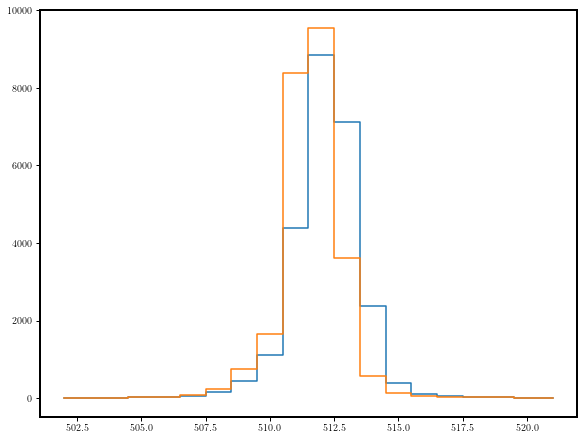

In [57]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)

ax.step(ccdx_array[HeI_D3_slice_2],np.average(helium_trans_mapcoor[:5,HeI_D3_slice_2],axis=0),where="mid")
ax.step(np.arange(HeI_D3_slice_2.start+xstart_pixel, HeI_D3_slice_2.stop+xstart_pixel), 
        np.average(helium_im_aver[350:355,HeI_D3_slice_2.start+xstart_pixel:HeI_D3_slice_2.stop+xstart_pixel],axis=0),where="mid")

In [58]:
HeI_D3_model_2_row_data = np.average(helium_trans_mapcoor[:,HeI_D3_slice_2].reshape(-1,5,HeI_D3_slice_2.stop - HeI_D3_slice_2.start),axis=1)
HeI_D3_model_2_row = SpectrumFitRow(data=HeI_D3_model_2_row_data, wvl=ccdx_array[HeI_D3_slice_2],line_number=1,line_wvl_init=[512],
                    int_max_init=[4000],fwhm_init=[1],same_width=False)
HeI_D3_model_2_row.run_lse(absolute_sigma=False)


array([[<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<A

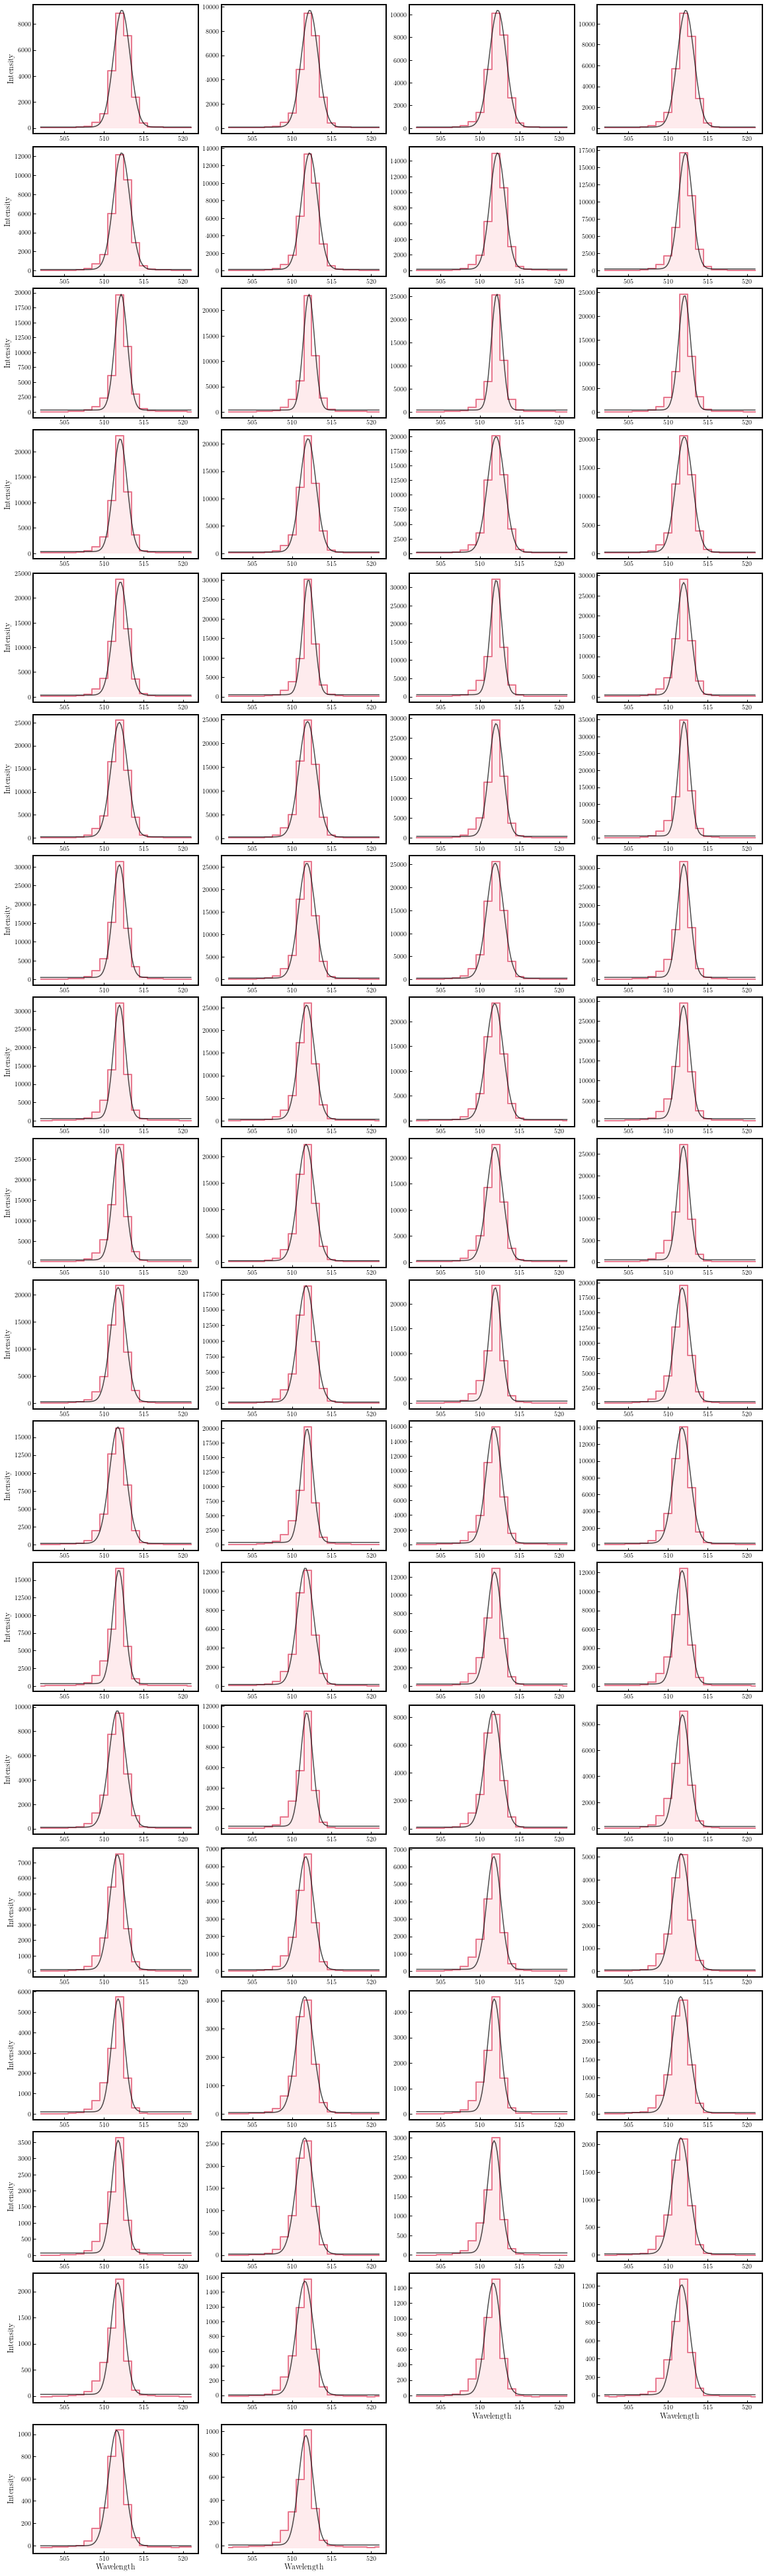

In [59]:
HeI_D3_model_2_row.plot_fit()

<AxesSubplot:ylabel='FWHM $\\Delta \\lambda$'>

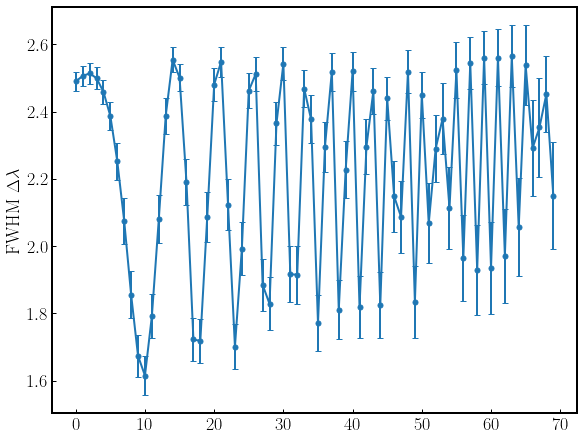

In [60]:
HeI_D3_model_2_row.plot_variation()

In [61]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_D3_2_width_red_curcorr.h5", 'w') as hf:
    df_linewidth = hf.create_dataset("HeI_D3_fwhm",  data=HeI_D3_model_2_row.fwhm_fit)
    df_linewidth_err = hf.create_dataset("HeI_D3_fwhm_err",  data=HeI_D3_model_2_row.fwhm_err)
    df_linewidth.attrs["xstart_pixel"] = xstart_pixel
    df_linewidth.attrs["xend_pixel"] = xend_pixel

In [62]:
HeI_6678_model_2_row_data = np.average(helium_trans_mapcoor[:,HeI_6678_slice_2].reshape(-1,5,HeI_6678_slice_2.stop - HeI_6678_slice_2.start),axis=1)
HeI_6678_model_2_row = SpectrumFitRow(data=HeI_6678_model_2_row_data, wvl=ccdx_array[HeI_6678_slice_2],line_number=1,line_wvl_init=[824],
                    int_max_init=[4000],fwhm_init=[1],same_width=False)
HeI_6678_model_2_row.run_lse(absolute_sigma=False)


array([[<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='Intensity'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<A

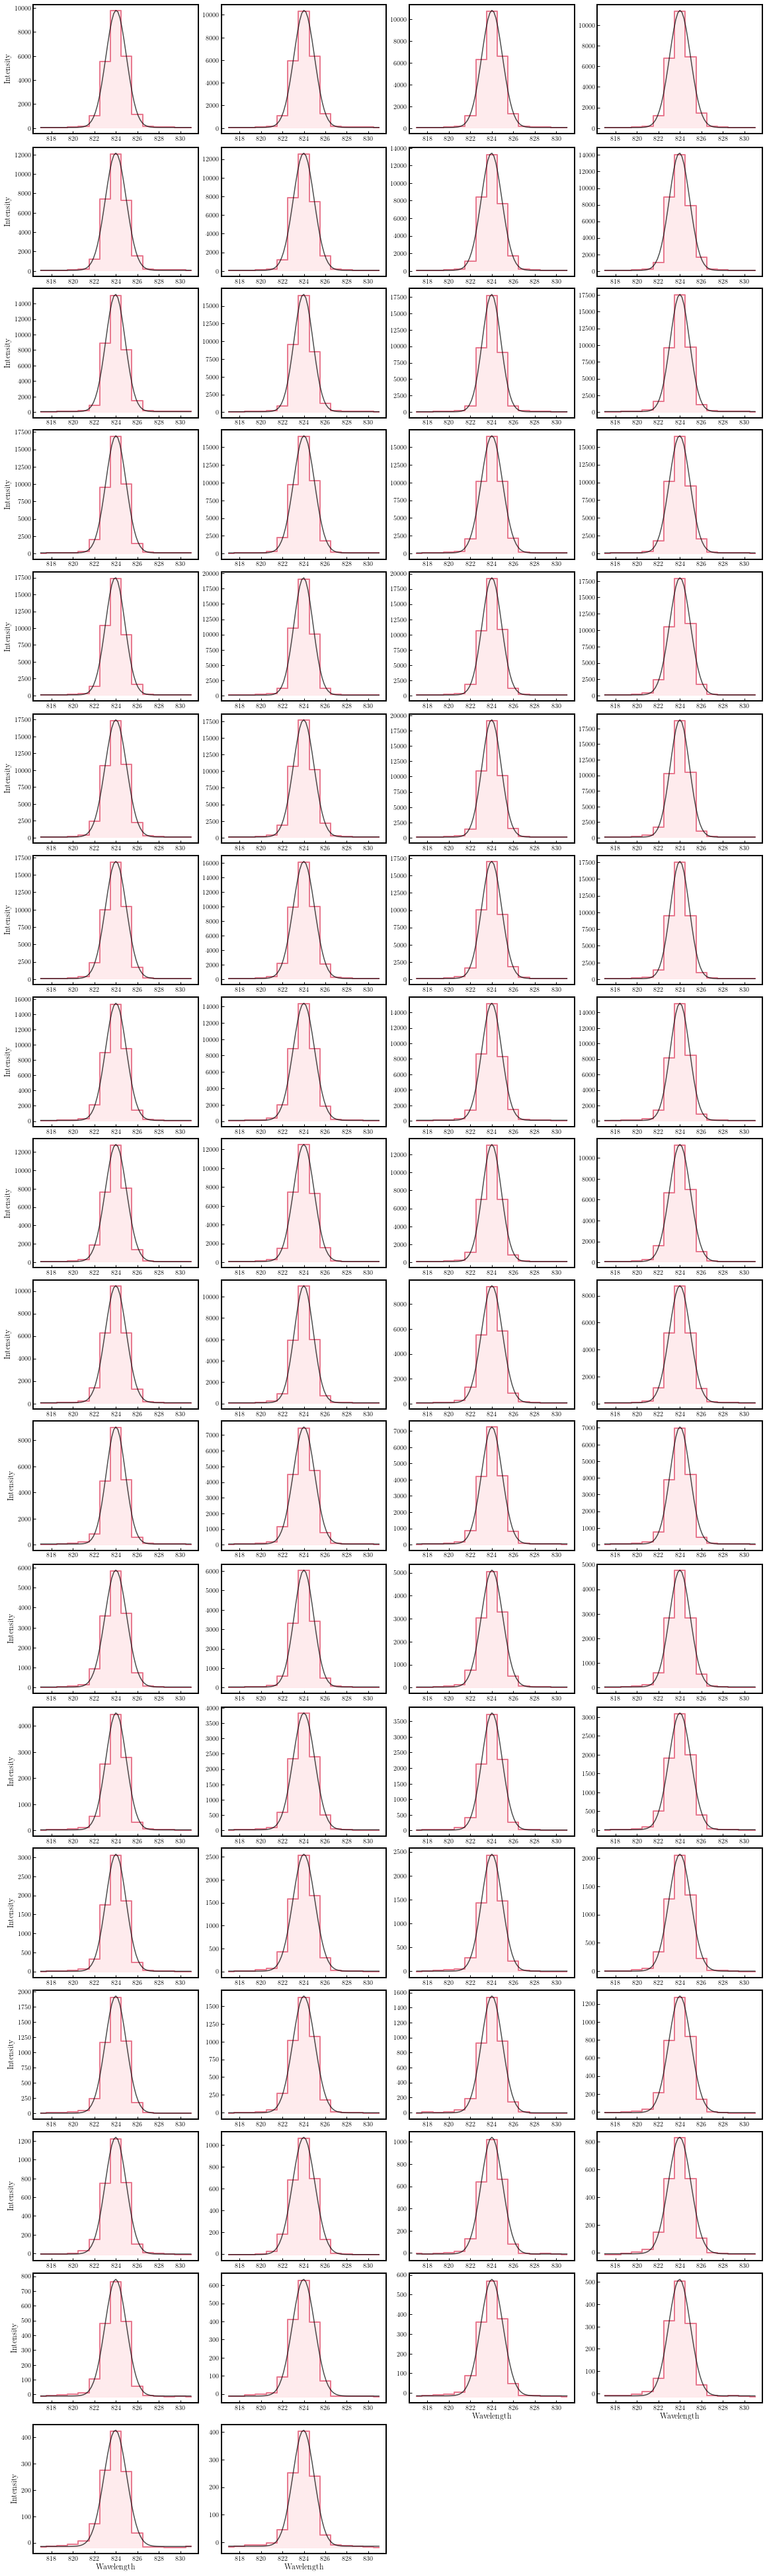

In [63]:
HeI_6678_model_2_row.plot_fit()

<AxesSubplot:ylabel='FWHM $\\Delta \\lambda$'>

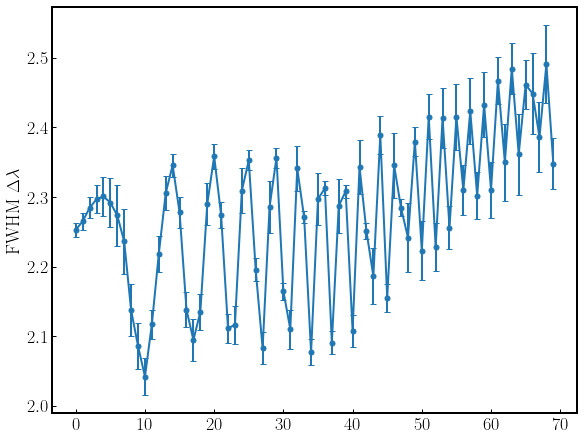

In [64]:
HeI_6678_model_2_row.plot_variation()

<AxesSubplot:ylabel='Total Intensity $I_0$'>

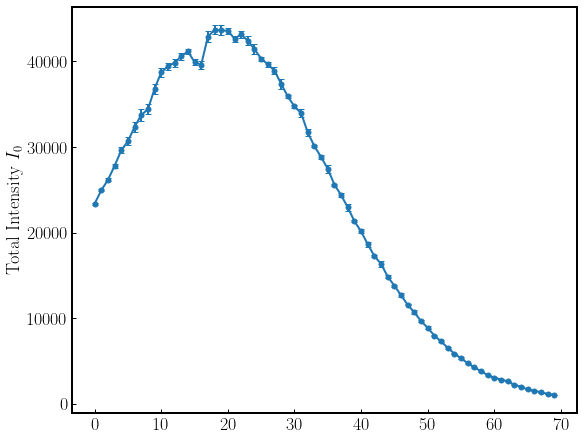

In [65]:
HeI_6678_model_2_row.plot_variation(var="int")

In [66]:
with h5py.File("../../sav/Eclipse/InstWidth/HeI_6678_2_width_red_curcorr.h5", 'w') as hf:
    df_linewidth = hf.create_dataset("HeI_6678_fwhm",  data=HeI_6678_model_2_row.fwhm_fit)
    df_linewidth_err = hf.create_dataset("HeI_6678_fwhm_err",  data=HeI_6678_model_2_row.fwhm_err)
    df_linewidth.attrs["xstart_pixel"] = xstart_pixel
    df_linewidth.attrs["xend_pixel"] = xend_pixel